# Разработка агента для решения задачи с конечным набором состояний и действий

In [2]:
import numpy as np
import gymnasium as gym
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Эпсилон-жадная политика

## Формула

In [3]:
def get_epsilon_greedy_action(q_matrix, state, epsilon, n_action):
    probs = torch.ones(n_action) * epsilon / n_action
    best_action = torch.argmax(q_matrix[state]).item()
    probs[best_action] += 1 - epsilon

    return torch.multinomial(probs, 1).item()

## Визуализация простого примера для понимания

- Допустим у нас есть среда с 2 состояниями и 2 действиями, и мы явно знаем награду в каждом случае. 
- Пускай в состоянии 0 действие 0 дает награду 3, а действие 1 - 2. Также зададим награды для второго состояния.
- Пускай среда всегда находится в состоянии 1.

В таком случае логично всегда выбирать действие 0, так как награда выше, но эпсилон-жадная стратегия позволяет исследовать среду (что будет полезно в реальных задачах), таким образом при снижении эпсилон мы чаще будем выбирать действие, дающее большую награду. Визуализируем это.

In [40]:
q_matrix = torch.tensor([[3, 2], [2, 5]])
state = 0
n_action = 2

epsilons = []
actions = []
for epsilon in np.arange(1, 0, -0.01):
    epsilons.append(epsilon)
    actions.append(get_epsilon_greedy_action(q_matrix=q_matrix, state=state, epsilon=epsilon, n_action=2))

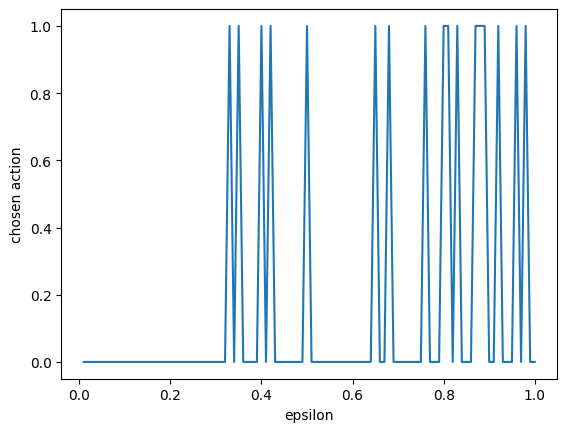

In [42]:
plt.plot(epsilons, actions)
plt.xlabel('epsilon')
plt.ylabel('chosen action')
plt.show()

# Реализация алгоритма Q-learning

In [4]:
def q_learning(env, n_episodes, update_epsilon, gamma, max_step_per_episode=1000, learning_rate=0.5):
    n_state = env.observation_space.n
    n_actions = env.action_space.n
    # Инициализация Q-функци
    q_matrix = torch.zeros((n_state, n_actions)) 
    # Начинаем со случайного выбора действий (для исследования)
    epsilon = 1 

    # Инициализируем переменные для хранения награды, длины эпизодов и средней награды за последние 100 эпизодов
    total_rewards = []
    length_episodes = []
    avg_rewards_last_100_episodes = []
    
    for episode in range(n_episodes):
        total_reward_episode = 0 # В этой переменной копим награду для эпизода
        state, _ = env.reset()
        is_done = False
        num_step = 0

        # Запускаем цикл, из которого выйдем либо при завершении эпизода, либо при достижении максимально допустимого числа шагов
        while not is_done and num_step < max_step_per_episode:
            # Выбираем действие на основе стратегии, делаем шаг в среде и получаем результат
            action = get_epsilon_greedy_action(q_matrix, state, epsilon, n_actions)
            next_state, reward, is_done, _, _ = env.step(action)

            # Обновление q-функции, общей награды для эпизода, состояния среды
            q_matrix[state][action] += learning_rate * (
                reward + gamma * torch.max(q_matrix[next_state]) - q_matrix[state][action]
            )
            total_reward_episode += reward
            state = next_state

            num_step += 1

        # Обновляем эпсилон
        epsilon = max(0, epsilon - update_epsilon)

        # Фиксируем награду для эпизода и длину эпизода
        total_rewards.append(total_reward_episode)
        length_episodes.append(num_step)
        avg_rewards_last_100_episodes.append(np.mean(total_rewards[-100:]))

    policy = {}
    for state in range(len(q_matrix)):
        policy[state] = torch.argmax(q_matrix[state]).item()

    # Возвращаем вознаграждение, длину каждого эпизода, среднее вознаграждение за последние 100 эпизодов,
    # а также q-матрицу и оптимальную стратегию
    return total_rewards, length_episodes, avg_rewards_last_100_episodes, q_matrix, policy

# Среда - Taxi-v3

## Инициализация и обучение агента

In [80]:
env_taxi = gym.make("Taxi-v3")
print(env_taxi.observation_space)
print(env_taxi.action_space)
print(env_taxi.spec.reward_threshold)

Discrete(500)
Discrete(6)
8


Подробное описание среды можно почитать [здесь](https://gymnasium.farama.org/environments/toy_text/taxi/).

In [81]:
taxi_rewards, taxi_length, avg_rewards_100, taxi_q, taxi_policy = q_learning(
    env=env_taxi, n_episodes=1000, update_epsilon=1/200, gamma=0.99, max_step_per_episode=1000, learning_rate=0.5
)

После обучения имеем q-матрицу и политику, что можно считать готовым агентом.

In [90]:
taxi_q.size(), len(taxi_policy)

(torch.Size([500, 6]), 500)

## Результаты

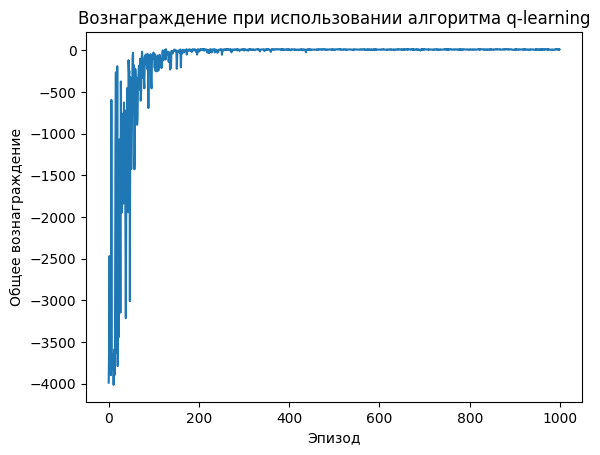

In [82]:
plt.plot(taxi_rewards)
plt.title('Вознаграждение при использовании алгоритма q-learning')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

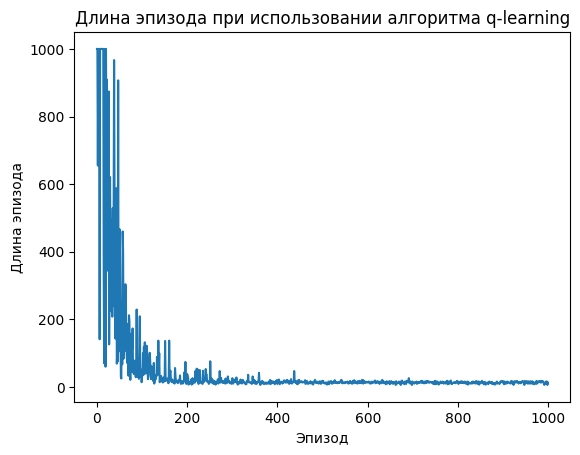

In [83]:
plt.plot(taxi_length)
plt.title('Длина эпизода при использовании алгоритма q-learning')
plt.xlabel('Эпизод')
plt.ylabel('Длина эпизода')
plt.show()

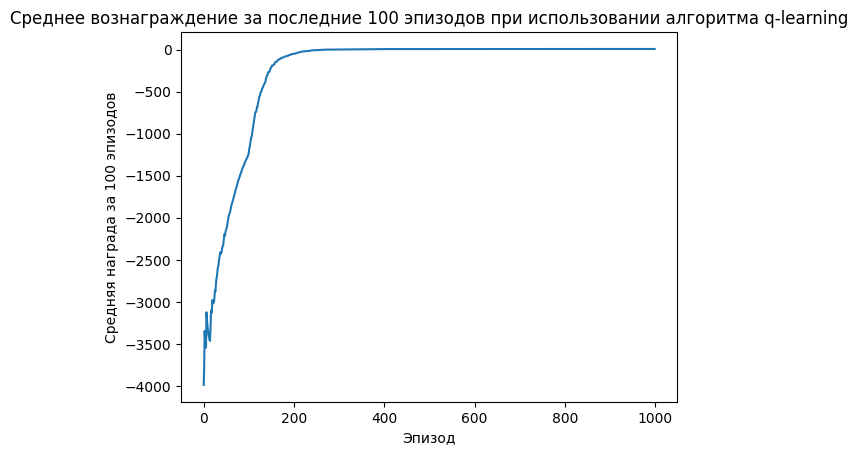

In [85]:
plt.plot(avg_rewards_100)
plt.title('Среднее вознаграждение за последние 100 эпизодов при использовании алгоритма q-learning')
plt.xlabel('Эпизод')
plt.ylabel('Средняя награда за 100 эпизодов')
plt.show()

## Влияние параметров обучения на результат

Поварьируем параметры алгоритма и посмотрим, как они влияют на обучение.

### Скорость обновления эпсилон

Быстрое обновление эпсилон.

In [106]:
rewards_test_0 = q_learning(
    env=env_taxi, n_episodes=1000, update_epsilon=1/20, gamma=0.99, max_step_per_episode=1000, learning_rate=0.5
)[0]

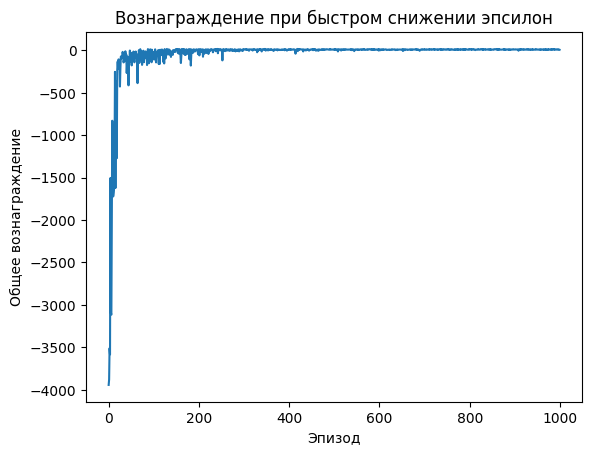

In [107]:
plt.plot(rewards_test_0)
plt.title('Вознаграждение при быстром снижении эпсилон')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

Медленное обновление эпсилон.

In [108]:
rewards_test_1 = q_learning(
    env=env_taxi, n_episodes=1000, update_epsilon=1/400, gamma=0.99, max_step_per_episode=1000, learning_rate=0.5
)[0]

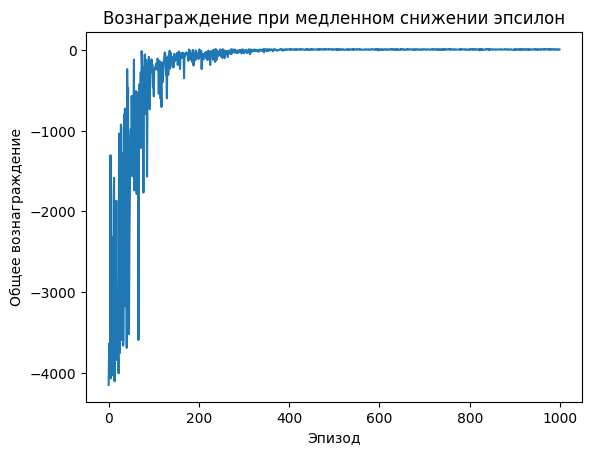

In [109]:
plt.plot(rewards_test_1)
plt.title('Вознаграждение при медленном снижении эпсилон')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

При быстром снижении эпсилон алгоритм быстрее начинает работать по оптимальной стратегии, и в данной среде это оправдано из-за ее простоты. При медленном снижении эпсилон видно, что алгоритм какое-то время тратит на изучение самой среды, а лишь потом начинает действовать в соответствии с оптимальной политикой.

### Коэффициент дисконтирования

Очень низкий.

In [126]:
rewards_gamma_0 = q_learning(
    env=env_taxi, n_episodes=1000, update_epsilon=1/200, gamma=0.3, max_step_per_episode=1000, learning_rate=0.5
)[0]

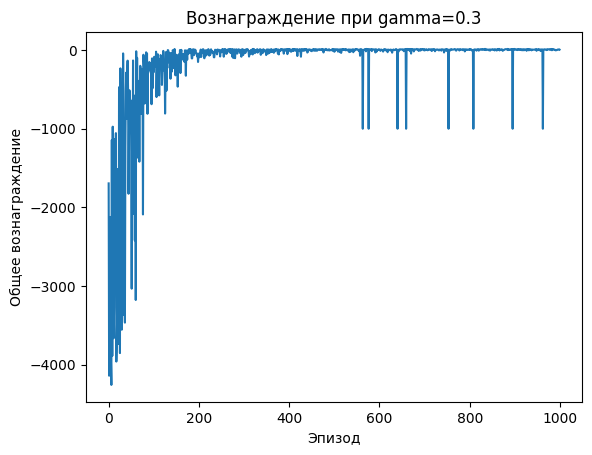

In [127]:
plt.plot(rewards_gamma_0)
plt.title('Вознаграждение при gamma=0.3')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

Средний.

In [128]:
rewards_gamma_1 = q_learning(
    env=env_taxi, n_episodes=1000, update_epsilon=1/200, gamma=0.9, max_step_per_episode=1000, learning_rate=0.5
)[0]

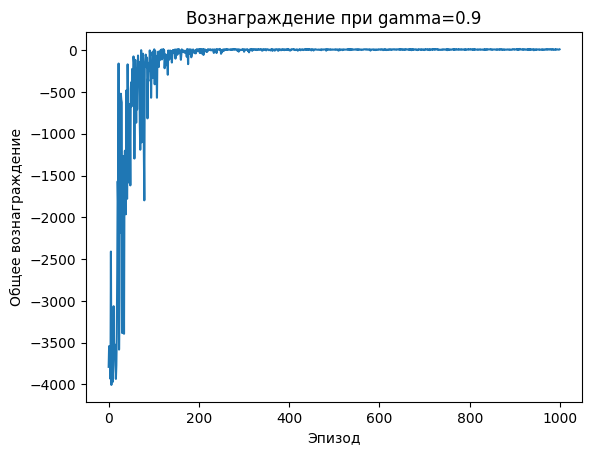

In [129]:
plt.plot(rewards_gamma_1)
plt.title('Вознаграждение при gamma=0.9')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

Очень высокий.

In [130]:
rewards_gamma_2 = q_learning(
    env=env_taxi, n_episodes=1000, update_epsilon=1/200, gamma=0.999, max_step_per_episode=1000, learning_rate=0.5
)[0]

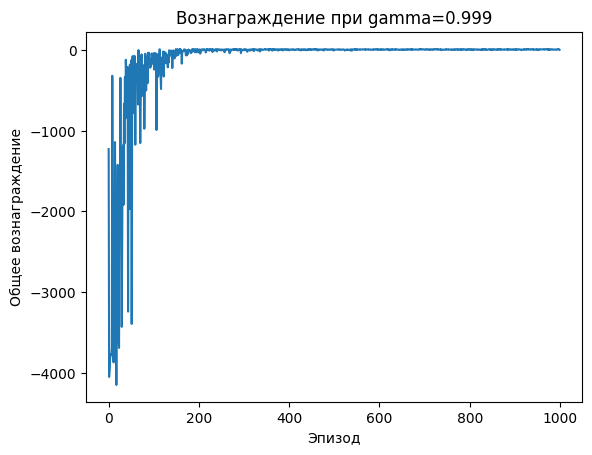

In [131]:
plt.plot(rewards_gamma_2)
plt.title('Вознаграждение при gamma=0.999')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

Видно, что при низком коэффициенте дисконтирования алгоритм ведет себя странно. Если же установить его в разумные рамки, то обучение агента в выбранной среде идет нормально.

### Скорость обучения

Скорость обучения отвечает за то, как быстро мы обновляем q-функцию. Попробуем очень маленькие и очень большие значения параметра.

In [136]:
rewards_alpha_0 = q_learning(
    env=env_taxi, n_episodes=1000, update_epsilon=1/200, gamma=0.99, max_step_per_episode=1000, learning_rate=0.01
)[0]

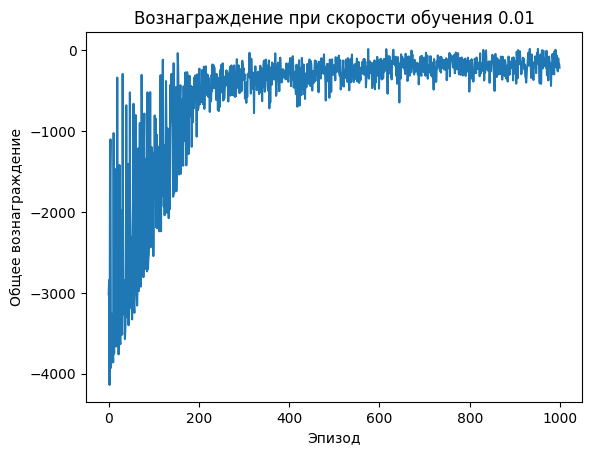

In [138]:
plt.plot(rewards_alpha_0)
plt.title('Вознаграждение при скорости обучения 0.01')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

In [148]:
rewards_alpha_1 = q_learning(
    env=env_taxi, n_episodes=1000, update_epsilon=1/200, gamma=0.99, max_step_per_episode=1000, learning_rate=1.1
)[0]

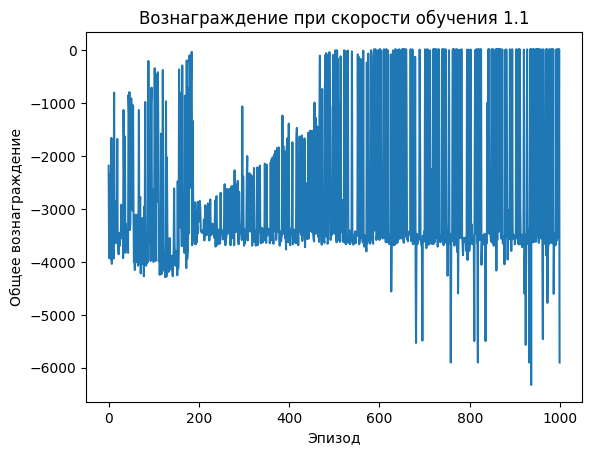

In [149]:
plt.plot(rewards_alpha_1)
plt.title('Вознаграждение при скорости обучения 1.1')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

При медленной скорости обучения алгоритм медленно сходится. Если же поставить аномально высокую скорость обучения, то алгоритм банально не может обучиться.

# Среда - CliffWalking

## Инициализация и обучение

In [5]:
env_cliff = gym.make('CliffWalking-v0')
print(env_cliff.observation_space)
print(env_cliff.action_space)
print(env_cliff.spec.reward_threshold)

Discrete(48)
Discrete(4)
None


Подробное описание среды можно почитать [здесь](https://gymnasium.farama.org/environments/toy_text/cliff_walking/).

In [17]:
cliff_rewards, cliff_length, avg_rewards_100, cliff_q, cliff_policy = q_learning(
    env=env_cliff, n_episodes=200, update_epsilon=1/100, gamma=0.99, max_step_per_episode=400, learning_rate=0.5
)

После обучения имеем q-матрицу и политику, что можно считать готовым агентом.

In [18]:
cliff_q.size(), len(cliff_policy)

(torch.Size([48, 4]), 48)

## Результаты

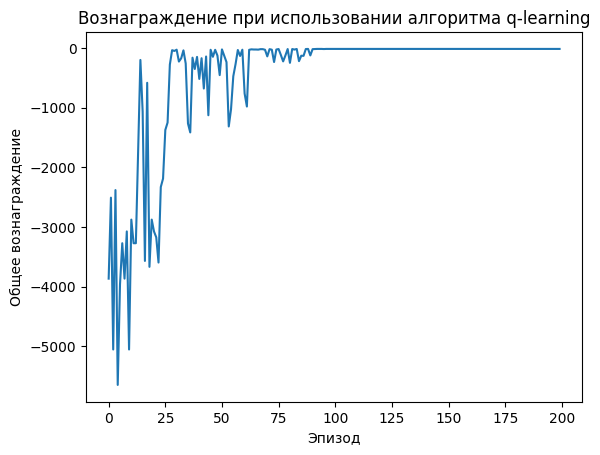

In [19]:
plt.plot(cliff_rewards)
plt.title('Вознаграждение при использовании алгоритма q-learning')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

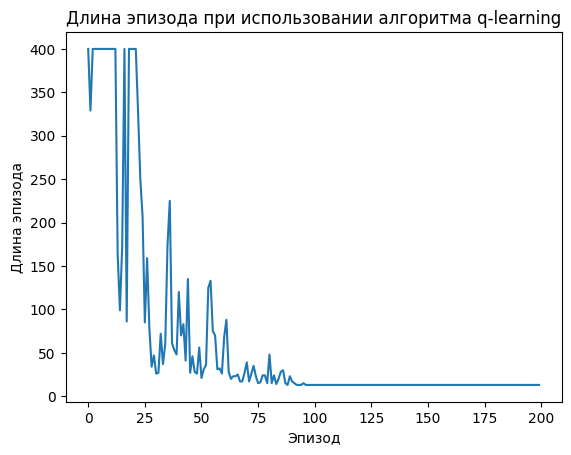

In [20]:
plt.plot(cliff_length)
plt.title('Длина эпизода при использовании алгоритма q-learning')
plt.xlabel('Эпизод')
plt.ylabel('Длина эпизода')
plt.show()

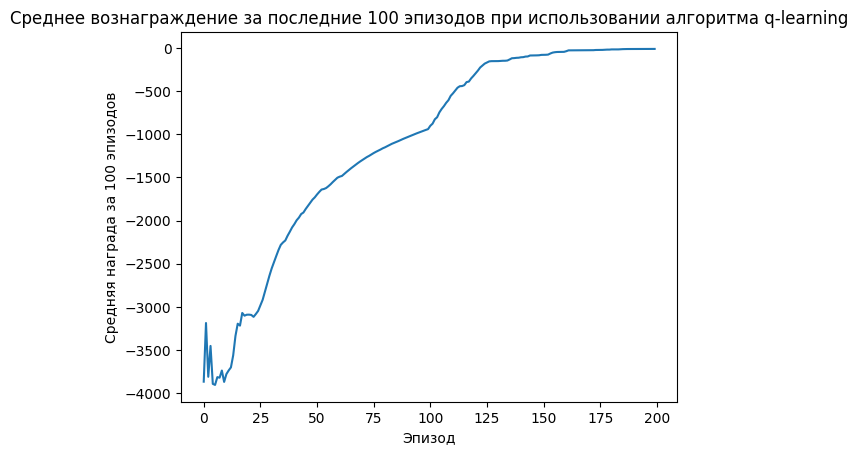

In [21]:
plt.plot(avg_rewards_100)
plt.title('Среднее вознаграждение за последние 100 эпизодов при использовании алгоритма q-learning')
plt.xlabel('Эпизод')
plt.ylabel('Средняя награда за 100 эпизодов')
plt.show()